# Определение перспективного тарифа для телеком компании


От коммерческого отдела получена задача проанализировать 2 тарифа федерального оператора сотовой связи "Мегалайн", с целью корректировки рекламного бюджета.<br/>

Данные представлены в 5 датафреймах:<br/>
- Информация о звонках;
- Информация об интернет-сессиях;
- Информация о сообщениях;
- Информация о тарифах;
- Информация о пользователях

**Задачи проекта:**
1) Познакомиться с данными и сделать первые выводы с чем предстоит работать;<br/>
2) Провести предобработку;<br/>
3) Посчитать выручку по каждому пользователю;<br/>
4) Провести анализ данных;<br/>
5) Проверка гипотез:<br/>
- Проверить гипотезу о том, что средняя выручка по тарифу **"Ультра"** не отличается от средней выручки по тарифу **"Смарт"**;<br/>
- Проверить гипотезу о том, что средняя выручка по пользователям Москвы не отличается от выручки по пользователям с другиз регионов;<br/>

7) Подвести итоги проделанной работы.<br/>

**Цель проекта** - выявить более выгодный тариф для компании на основе анализа поведения клиентов.


In [1]:
# импорт бибилиотек, необходимых для работы
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

## Изучение общей информации

In [2]:
# загрузка данных
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
# вывод информации и первых 5 строк каждого ДФ
for data in [calls, internet, messages, tariffs, users]:
    print(print('----------------'), data.info(), print(), data.head())

----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

None None None        id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

None None None    Unn

In [4]:
# проверка данных на часто встречаемые значения и уникальность
#calls['duration'].value_counts()
#internet['mb_used'].value_counts()
#users['city'].unique()
#users['first_name'].unique()
#users['last_name'].unique()
#users['tariff'].unique()

In [5]:
# перевод столбца "mb_per_month_included" в гигабайты, тип данных int и переименование столбца
tariffs['mb_per_month_included'] = (tariffs['mb_per_month_included'] / 1024).astype('int')
tariffs = tariffs.rename(columns={'mb_per_month_included' : 'gb_per_month_included'})
tariffs

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


### Вывод
Предоставлено 5 таблиц с разными данными по клиентам.<br/>
Всего 500 наблюдений по клиентам с разными **user_id** за **2018 год**. Прежде чем приступать к анализу необходимо провести предобработку:
1) Изменить тип данных в столбцах с датой;<br/>
2) Добавить столбцы с месяцем активности;<br/>
2) Округлить данные в столбце **"Длительность звонка"** таблицы **"Информация о звонках"** до целых минут в большую сторону, изменить тип данных на **int**;<br/>
3) Изменить тип данных на **int** столбец **"Объем потраченного трафика в МБ"** в таблице **"Информация о интернет-сессиях"**, т.к. нас интересую мегабайты, а не килобайты; <br/>

Ошибочно выглядят данные **0,00 минут** в таблице **"Информация о звонках"** в столбце **"Длительность звонка"**. Скорее всего так записывались звонки менее **1 минуты**, поэтому буду заменять на единицу.<br/>
 Такая же история с данными в столбце **"Объем потраченного трафика в МБ"** в таблице **"Информация о интернет-сессиях"**. Поступлю таким же образом. Считаю нецелесообразно удалять такие данные, так как их очень много.<br/>

Пропуски в таблице **"Информация о пользователях"** в столбце **"Дата прекращения пользования тарифом"** оставлю без изменений, т.к. во-первых логически заменять их нечем, во-вторых так, возможно, отображается то, что клиент все еще пользуется тарифом. В любом случае по поводу этих двух моментов необходимо уточнить у коллег, ответственных за сборку данных.<br/>

В таблице **"Информация о пользователях"** данные в столбцах: **"city","first_name","last_name"** и **tariffs** " проверил-все города, имена, фамилии и название тарифов  указаны в одном стиле-приводить к нижнему регистру необязательно;<br/>
Больше пропусков и странностей на данном этапе не выявлено.


## Предобработка данных

In [6]:
# изменение типа данных на date_time
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'] , format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')

In [7]:
# проверка количества нулевых значений в столбцах "Длительность звонка"
# и "Объем потраченного трафика в МБ"
print(
    'Количество нулевых значений в столбце "Длительность звонка":',
    calls.loc[calls['duration'] == 0, 'duration'].value_counts()[0]
)
print(
    'Количество нулевых значений в столбце "Объем потраченного трафика в МБ":',
    internet.loc[internet['mb_used'] == 0, 'mb_used'].value_counts()[0]
)

Количество нулевых значений в столбце "Длительность звонка": 39613
Количество нулевых значений в столбце "Объем потраченного трафика в МБ": 19598


#### Нулевые аномалии в столбцах "Длительность звонка" и "Объем потраченного трафика"
О таких аномалиях необходимо уточнить у коллег, ответственных за сбор данных, чтобы четко понимать что под нулями подразумевается. На данном этапе предположу, что в длительности звонков так указаны звонки менее одной минуту(в ДФ не найдены данные со значениями от 0.01 до 0.99), и в связи с правилами пользования тарифом звонки менее одной минуты округляются до 1 минуты.<br/>
Что же каксается интернет сессий, то так, возможно, отображаюся неуждачные интренет-сессии, когда пользователь не смог выйти в сеть, поэтому основания заменять нули единицами нет. Т.к. оператор считает только трафик потраченный за месяц (в гигабайтах), то и округлять в большую сторону необходимо только после группировки по месяцам.

In [8]:
# округление значений в большую сторону,
# изменение типа данных на int и замена нулей на единицы в столбце "Длительность звонка"
# добавление столбца с месяцем
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')
calls.loc[calls['duration'] == 0, 'duration'] = 1
calls['month'] = calls['call_date'].dt.month

# добавление столбца с месяцем в таблицу "Информация о сообщениях" и "Объем потраченного трафика в МБ"
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month

print('--------------------------------------------------------------')
print('После обработки типов данных, округления и добавления столбцов')
print('--------------------------------------------------------------')
for data in [calls, internet, messages, tariffs, users]:
    print(data.info(), '----------------')

--------------------------------------------------------------
После обработки типов данных, округления и добавления столбцов
--------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
month        202607 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 7.7+ MB
None ----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
month           149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.

In [9]:
# создание сводных таблиц по каждому ДФ для последующего объединения в один
users_pivot = users
# имя и фамилия клиентов объединил в один столбец для удобства дальнейшего импользования ДФ
users_pivot['first_name'] = (
    users_pivot[['last_name', 'first_name']]
    .apply(lambda x: ' '.join(x), axis = 1)
)
users_pivot = users.set_index('user_id')
users_pivot = users_pivot.drop(['last_name'], axis = 1)
users_pivot.columns = 'age', 'churn_date', 'city', 'user_name', 'reg_date', 'tariff_name' 


calls_pivot = calls.pivot_table(
    index = ['user_id', 'month'], values = 'duration', aggfunc = 'sum'
)

internet_pivot = internet.pivot_table(
    index = ['user_id', 'month'], values = 'mb_used', aggfunc = 'sum'
)
# перевод мегабайтов в гигабайты, округляю в большую сторону и меняю тип данных на int
internet_pivot['mb_used'] = (internet_pivot['mb_used'] / 1024).apply(np.ceil).astype('int')
# изменение названия столбца
internet_pivot = internet_pivot.rename(columns={'mb_used': 'gb_used'})

messages_pivot = messages.pivot_table(
    index = ['user_id', 'month'], values = 'message_date', aggfunc = 'count'
)


In [10]:
first_merge = calls_pivot.merge(internet_pivot, on = ['user_id', 'month'], how = 'outer')
second_merge = first_merge.merge(messages_pivot, on = ['user_id', 'month'], how = 'outer')
second_merge.columns = 'duration', 'gb_used', 'messages'
second_merge = second_merge.reset_index()
grouped_df = users_pivot.merge(second_merge, on = ['user_id'], how = 'outer')

#grouped_df = users_pivot.join(second_merge)
#second_merge.head()
grouped_df.set_index('user_id')
grouped_df.head()

,user_id,age,churn_date,city,user_name,reg_date,tariff_name,month,duration,gb_used,messages
0,1000,52,NaT,Краснодар,Верещагин Рафаил,2018-05-25,ultra,5.0,164.0,3.0,22.0
1,1000,52,NaT,Краснодар,Верещагин Рафаил,2018-05-25,ultra,6.0,187.0,23.0,60.0
2,1000,52,NaT,Краснодар,Верещагин Рафаил,2018-05-25,ultra,7.0,346.0,14.0,75.0
3,1000,52,NaT,Краснодар,Верещагин Рафаил,2018-05-25,ultra,8.0,418.0,14.0,81.0
4,1000,52,NaT,Краснодар,Верещагин Рафаил,2018-05-25,ultra,9.0,478.0,15.0,57.0


In [11]:
#grouped_df.query('month == "NaN"')
#grouped_df.query('duration == "NaN"')
#grouped_df.query('gb_used == "NaN"')
#grouped_df.query('messages == "NaN"')

In [12]:
print('Количество пропусков в данных после объединения таблиц (до замены):')
print(grouped_df.isna().sum())
display(grouped_df.info())

# пропуски в столбце "duration", "messages", "mb_used" заполняю нулями, 
# пустые значения в столбце "month" удаляю (2 строки с полностью пустыми данными)
# и меняю тип на int (кроме столбца "churn_date")
grouped_df['messages']= grouped_df['messages'].fillna(0).astype('int')
grouped_df['gb_used'] = grouped_df['gb_used'].fillna(0).astype('int')
grouped_df['duration'] = grouped_df['duration'].fillna(0).astype('int')
grouped_df.dropna(subset = ['month'], inplace = True)
grouped_df['month'] = grouped_df['month'].astype('int')
print('Количество пропусков данных после объединения таблиц (после замены):')
print(grouped_df.isna().sum())
print('Количество дубликатов после объединения таблиц:')
print(grouped_df.duplicated().sum())

Количество пропусков в данных после объединения таблиц (до замены):
user_id           0
age               0
churn_date     3027
city              0
user_name         0
reg_date          0
tariff_name       0
month             2
duration         42
gb_used          13
messages        499
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 11 columns):
user_id        3216 non-null int64
age            3216 non-null int64
churn_date     189 non-null datetime64[ns]
city           3216 non-null object
user_name      3216 non-null object
reg_date       3216 non-null datetime64[ns]
tariff_name    3216 non-null object
month          3214 non-null float64
duration       3174 non-null float64
gb_used        3203 non-null float64
messages       2717 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(2), object(3)
memory usage: 301.5+ KB


None

Количество пропусков данных после объединения таблиц (после замены):
user_id           0
age               0
churn_date     3027
city              0
user_name         0
reg_date          0
tariff_name       0
month             0
duration          0
gb_used           0
messages          0
dtype: int64
Количество дубликатов после объединения таблиц:
0


### Результат предобработки
Изменены типы данных в столбцах с датами, добавлены новые столбцы с месяцем проведенной операции. Данные в столбцах **"Длительность звонка"** округлены в большую сторону и переведены в тип **int**. Также нулевые значения изменены на единицы.<br/>
Столбец "mb_used" переведен в гигабайты, соответствующе назван и изменен тип данных на **int**.
После объединения появились пустые значения в столбцах **"Месяц"**, **"Длительность звонка"**, **"Объем потраченного трафика в МБ"**, **"Количество сообщений"**, которые были заменены нули(строки с пустыми значениями по мясацам были удалены, т.к. в этих строках не содержалось никакой информации о клиентской активности). Сделано это исходя из следующей логики - каждый клиент индивидуален в пользовании сотовой связью, клиент может как совсем не писать сообщения, так и не совершать звонки, а делать это все через мессенджеры.<br/>
**P.S.** Проверил гипотезу, что нулевые значения в столбце  **"Объем потраченного трафика в МБ"** относятся только к поджилым пользователям, но это не так.


## Расчет выручки

In [13]:
# присоединение таблицы спараметрами тарифов для удобства расчета выручки
grouped_df = grouped_df.reset_index()
grouped_df = grouped_df.merge(tariffs, on = 'tariff_name', how = 'left')
# расчет использования лимитов
grouped_df['minutes_overrun'] = grouped_df['duration'] - grouped_df['minutes_included']
grouped_df['messages_overrun'] = grouped_df['messages'] - grouped_df['messages_included']
grouped_df['gb_overrun'] = grouped_df['gb_used'] - grouped_df['gb_per_month_included']

# функция для расчета выручки по каждому клиенту
def det_revenue(row):
    revenue_by_min = 0
    revenue_by_messages = 0
    revenue_by_mb = 0
       
    if row['minutes_overrun'] > 0:
        revenue_by_min = row['minutes_overrun'] * row['rub_per_minute']
    if row['gb_overrun'] > 0:
        revenue_by_mb = row['gb_overrun'] * row['rub_per_gb']
    if row['messages_overrun'] > 0:
        revenue_by_messages = row['messages_overrun'] * row['rub_per_message']
        
    return revenue_by_min + revenue_by_mb + revenue_by_messages + row['rub_monthly_fee']
    
grouped_df['revenue'] = grouped_df.apply(det_revenue, axis = 1).astype('int')
# установка столбцов в качестве индексов
grouped_df = grouped_df.set_index(['user_id', 'month'])
# удаление далее неиспользуемых столбцов из финального ДФ
grouped_df = grouped_df.drop(
    ['index','messages_included', 'gb_per_month_included','minutes_included'
     , 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute'
     , 'minutes_overrun', 'messages_overrun','gb_overrun'], axis = 1
)
grouped_df.head(15)

age churn_date         city          user_name   reg_date  \
user_id month                                                              
1000    5       52        NaT    Краснодар   Верещагин Рафаил 2018-05-25   
        6       52        NaT    Краснодар   Верещагин Рафаил 2018-05-25   
        7       52        NaT    Краснодар   Верещагин Рафаил 2018-05-25   
        8       52        NaT    Краснодар   Верещагин Рафаил 2018-05-25   
        9       52        NaT    Краснодар   Верещагин Рафаил 2018-05-25   
        10      52        NaT    Краснодар   Верещагин Рафаил 2018-05-25   
        11      52        NaT    Краснодар   Верещагин Рафаил 2018-05-25   
        12      52        NaT    Краснодар   Верещагин Рафаил 2018-05-25   
1001    11      41        NaT       Москва          Ежов Иван 2018-11-01   
        12      41        NaT       Москва          Ежов Иван 2018-11-01   
1002    6       59        NaT  Стерлитамак  Абрамович Евгений 2018-06-17   
        7       59        NaT  Стерлитамак  Абрамович Евгений 2018-06-17   
        8       59        NaT  Стерлитамак  Абрамович Евгений 2018-06-17   
        9       59        NaT  Стерлитамак  Абрамович Евгений 2018-06-17   
        10      59        NaT  Стерлитамак  Абрамович Евгений 2018-06-17   

              tariff_name  duration  gb_used  messages  revenue  
user_id month                                                    
1000    5           ultra       164        3        22     1950  
        6           ultra       187       23        60     1950  
        7           ultra       346       14        75     1950  
        8           ultra       418       14        81     1950  
        9           ultra       478       15        57     1950  
        10          ultra       363       15        73     1950  
        11          ultra       344       15        58     1950  
        12          ultra       341       10        70     1950  
1001    11          smart       444       18         0     1150  
        12          smart       430       14         0      550  
1002    6           smart       118       11         4      550  
        7           smart       219       18        11     1150  
        8           smart       294       20        13     1550  
        9           smart       217       17         4      950  
        10          smart       221       14        10      550

### Вывод
После расчета выручки можно увидеть первоначальную тенденцию, что с пользователей тарифа **Ультра** оператор получает не более абонентской платы, а с пользователей тарифа **Смарт** больше ежемесячной абонентской платы. <br/>
Собраный ДФ можно использовать для дальнейшего анализа. Также ДФ имеет удобный вид и вмещает в себя всю информацию, которую могут использовать другие отделы.

## Анализ данных
### Проверка на аномалии


Тариф Ультра


,age,duration,gb_used,messages,revenue
count,985.000000,985.000000,985.000000,985.000000,985.000000
mean,46.834518,540.779695,19.494416,49.363452,2070.152284
std,17.107979,325.738740,9.853511,47.804457,376.187114
min,18.000000,0.000000,0.000000,0.000000,1950.000000
25%,30.000000,292.000000,12.000000,6.000000,1950.000000
50%,45.000000,532.000000,19.000000,38.000000,1950.000000
75%,63.000000,773.000000,27.000000,79.000000,1950.000000
max,75.000000,1727.000000,49.000000,224.000000,4800.000000



Тариф Смарт


,age,duration,gb_used,messages,revenue
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,46.556303,429.450875,16.328847,33.384029,1306.949305
std,16.353371,194.871174,5.747061,28.227876,827.546207
min,18.000000,0.000000,0.000000,0.000000,550.000000
25%,32.000000,291.000000,13.000000,10.000000,553.000000
50%,47.000000,435.000000,17.000000,28.000000,1062.000000
75%,62.000000,560.000000,20.000000,51.000000,1750.000000
max,75.000000,1471.000000,38.000000,143.000000,6824.000000


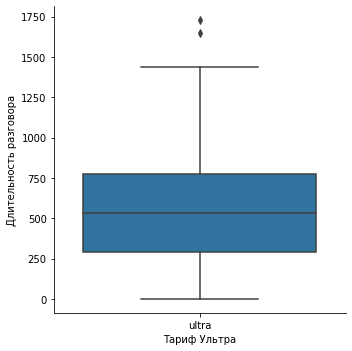

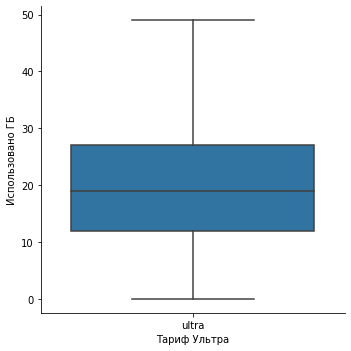

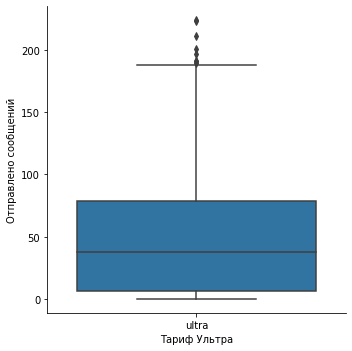

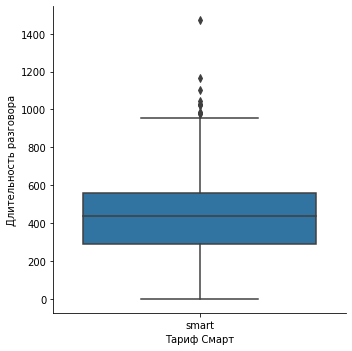

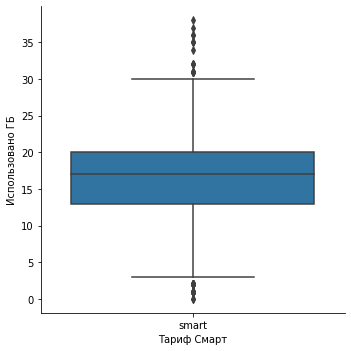

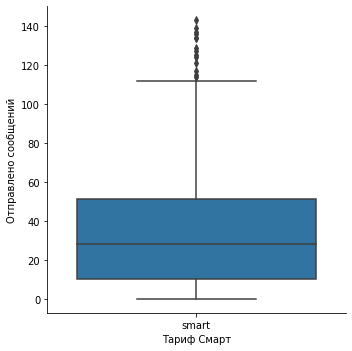

In [14]:
# посмотрим на боксплоты по трем параметрам каждого тарифа и описание данных
ultra_tariff = grouped_df.query('tariff_name == "ultra"')
smart_tariff = grouped_df.query('tariff_name == "smart"')
print('Тариф Ультра')
display(ultra_tariff.describe())
print()

dict_service = {'duration': 'Длительность разговора'
               , 'gb_used': 'Использовано ГБ'
               , 'messages':'Отправлено сообщений'}

for column in ['duration', 'gb_used', 'messages']:
    sns.catplot(x = 'tariff_name', y = column, kind = 'box', data = ultra_tariff)
    plt.xlabel("Тариф Ультра")
    plt.ylabel(dict_service[column])

print('Тариф Смарт')
display(smart_tariff.describe())
print()

for column in ['duration', 'gb_used', 'messages']:
    sns.catplot(x = 'tariff_name', y = column, kind = 'box', data = smart_tariff)
    plt.xlabel("Тариф Смарт")
    plt.ylabel(dict_service[column])

#### Вывод
Средние значения не сильно отличаются от медианных. Есть отличающиеся данные по длительности звонка, кол-ву использованного интернет траффика и кол-ву отправленных сообщений, но такие данные нельзя принимать за аномалии, т.к. каждый человек индивидуален в пользовании мобильной связью(звонки, интернет, sms-сообщения) и эти данные не выглядят какими-то фантастическими. Если удалить такие значения, то мы потеряем данные о клиентах, которые превышают лимиты по тарифам и приносят компании доход. В любом случае буду использовать медиану для дальнейшего анализа.<br/>
По описанию данных видно, что в среднем клиентам хватает предоставленных лимитов в рамках тарифа, но это в целом по пользователям, нас же интересует поведение каждого клиента в рамках лимитов тарифа.

### Описательная статистика

In [15]:
# таблица средних значений
# (сначала столбец тарифы сделал индексом, но потом возникли сложности с построением граффиков)
median_pivot = grouped_df.pivot_table(
    index = 'user_id', values = ['duration', 'gb_used', 'messages', 'revenue']
    , aggfunc = 'median' )

# добавляю столбец с наименованием тарифа
for user_id in users['user_id']:
    median_pivot.loc[user_id, 'tariff_name'] = users.loc[user_id-1000, 'tariff']

median_pivot.dropna(subset = ['duration'], inplace = True)
median_pivot.head()

,duration,gb_used,messages,revenue,tariff_name
user_id,,,,,
1000,345.0,14.5,65.0,1950.0,ultra
1001,437.0,16.0,0.0,850.0,smart
1002,221.0,18.0,11.0,1150.0,smart
1003,844.0,12.0,83.0,1950.0,ultra
1004,136.5,18.0,154.5,1950.0,ultra


In [16]:
# вывод среднего, стандартного отклонения и дисперсии
stat_tariff = grouped_df.pivot_table(
    index = 'tariff_name', values = ['duration', 'gb_used', 'messages']
    , aggfunc = {'duration': [np.mean, np.std, np.var]
    ,'gb_used': [np.mean, np.std, np.var]
    , 'messages': [np.mean, np.std, np.var]}
).style.format('{:.2f}')

stat_tariff

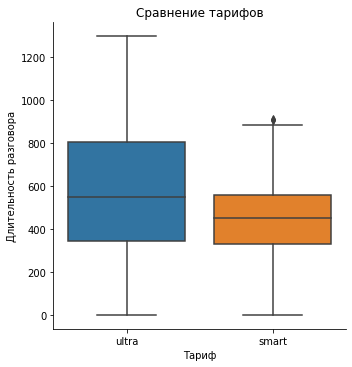

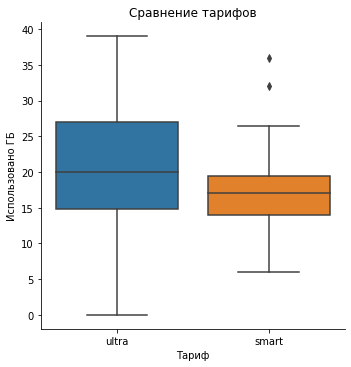

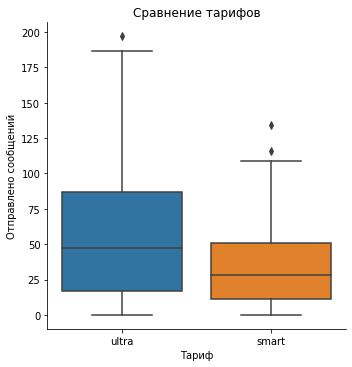

In [17]:
# посмотрим на боксплоты в сравнении
for column in ['duration', 'gb_used', 'messages']:
    sns.catplot(x = 'tariff_name', y = column, kind = 'box', data = median_pivot)
    plt.title('Сравнение тарифов')
    plt.xlabel('Тариф')
    plt.ylabel(dict_service[column])

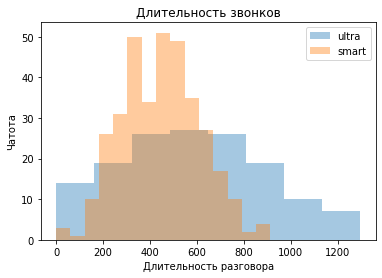

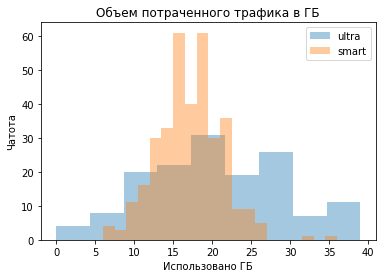

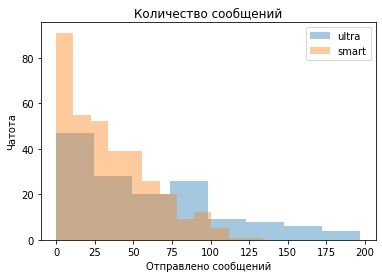

In [18]:
# гистограммы в сравнении
for tariff in ['ultra', 'smart']:
    (
        sns.distplot(median_pivot.query('tariff_name == @tariff')['duration']
                     , kde = False, label = tariff).set_title('Длительность звонков')
    )
_ = plt.legend(['ultra', 'smart'])
plt.xlabel('Длительность разговора')
plt.ylabel('Чатота')
plt.show()

for tariff in ['ultra', 'smart']:
    (
        sns.distplot(median_pivot.query('tariff_name == @tariff')['gb_used']
                     , kde = False, label = tariff).set_title('Объем потраченного трафика в ГБ')
    )
_ = plt.legend(['ultra', 'smart'])
plt.xlabel('Использовано ГБ')
plt.ylabel('Чатота')
plt.show()

for tariff in ['ultra', 'smart']:
    (
    sns.distplot(median_pivot.query('tariff_name == @tariff')['messages']
                 , kde = False, label = tariff).set_title('Количество сообщений')
    )
_ = plt.legend(['ultra', 'smart'])
plt.xlabel('Отправлено сообщений')
plt.ylabel('Чатота')
plt.show()

### Вывод
По боксплотам можно заметить, что медианное значение по каждому параметру тарифа **Ультра** очень близко к значению третьего квартиля тарифа **Смарт**. По гистограммам видно, что дисерсия тарифа **Ультра** превосходит дисперсию тарифа **Смарт**.<br/>
Также по ним можно описать поведение клиентов:
- **Длительность звонков** пользователей тарифа **Смарт** чаще всего в рамках лимита тарифа-**около 400 и 500 минут**, но и также часто выходят за рамки лимита по звонкам и длительность составляет ** 900 минут**; пользователи тарифа **Ультра** не выходят за рамки лимита;
- Половине абонентов тарифа **Смарт** не хватает лимита по **интернет-траффику**; абоненты тарифа **Ультра** чаще "укладываются" в предоставленный лимит;
- **Количество сообщений** по двум тарифам не выходит за рамки лимита, можно быть уверенными, что sms-сообщения непопулярны.<br/>

После анализа можно отметить, что абоненты тарифа **Смарт** чаще абонентов тарифа **Ультра** выходят за рамки лимитов по двум параметрам (длительность звонков, интернет-траффик) и, соответственно, чаще приносят компании дополнительный доход за оверлимиты.<br/>
Тем не менее нужно проверить от пользователей какого тарифа и города оператор получает больше выручки.


## Проверка гипотез

### Выручка по тарифам
**Нулевая гипотеза (Н0)** - средняя выручка тарифа **Ультра** равна средней выручке тарифа **Смарт**.<br/>
**Альтернативная гипотеза (Н1)** - средняя выручка тарифов различается.<br/>
**Уровень значимости (alpha)** = 5%

In [19]:
# срезы по тарифу и столбцу выручки
ultra_tariff = grouped_df.query('tariff_name == "ultra"')['revenue']
smart_tariff = grouped_df.query('tariff_name == "smart"')['revenue']

alpha = 0.05

results = st.ttest_ind(ultra_tariff, smart_tariff, equal_var = False)
print('р-значение:', results.pvalue)
if(results.pvalue < alpha):
    print('Нулевая гипотеза отвергнута - средние значения выручки по тарифам различаются')
else:
    print('Нулевую гипотезу отвергнуть не удалось - средние значения выручки по тарифам равны')
print()
print('-----------------------')
print('Средняя выручка тарифов')
grouped_df.pivot_table(index = 'tariff_name', values = 'revenue', aggfunc = 'median')

р-значение: 4.7897104728368674e-238
Нулевая гипотеза отвергнута - средние значения выручки по тарифам различаются

-----------------------
Средняя выручка тарифов


,revenue
tariff_name,
smart,1062
ultra,1950


### Вывод
В результате теста можно сказать с уверенностью в 95%, что выручка от пользователей тарифа **Ультра** отличается от выручки тарифа **Смарт**, несмотря на то, что таким пользователям, как правило, не хватает лимитов по услугам в рамках тарифа и они оплачивают дополнительно минути и гигабайты.

### Выручка по регионам
**Нулевая гипотеза (Н0)** - средняя выручка по пользователям из Москвы не отличается от средней выручки по пользователям из других городов.<br/>
**Альтернативная гипотеза (Н1)** - средняя выручка по пользователям Москвы и пользователям из других городов отличается.<br/>
**Уровень значимости (alpha)** = 5%

In [20]:
# срезы по городам(Москва и остальные города) и столбцу выручки
moscow_city = grouped_df.query('city == "Москва"')['revenue']
other_cities = grouped_df.query('city != "Москва"')['revenue']

alpha = 0.05

result = st.ttest_ind(moscow_city, other_cities, equal_var = False)
print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print('Нулевая гипотеза отвергнута - средние значения выручки по пользователям из Москвы и польхователяи из других городов различаются')
else:
    print('Нулевую гипотезу отвергнуть не удалось - средняя выручка по пользователям из Москвы не отличается от средней выручки по пользователям из других городов')
print()
print('-----------------------')
print('Средняя выручка по Москве:',moscow_city.mean().round())
print('Средняя выручка по другим городам:',other_cities.mean().round())
print('-----------------------')

p-значение: 0.5749090668370982
Нулевую гипотезу отвергнуть не удалось - средняя выручка по пользователям из Москвы не отличается от средней выручки по пользователям из других городов

-----------------------
Средняя выручка по Москве: 1556.0
Средняя выручка по другим городам: 1537.0
-----------------------


### Вывод
В результате теста неудалось отвергуть нулевую гипотезу. Это означает, что выручка от абонентов Москвы практически не отличается от выручки абонентов из других городов.

## Общий вывод
В результате проведенного статистического анализа можно подвести следующие итоги:<br/>
1) sms-сообщения не популярны у абонентов двух тарифов - за рамки предоставленных сообщений пользователи не выходят;<br/>
2) Пользователям тарифа **Смарт** чаще не хватает лимитов по **кол-ву минут** и **интернет-траффику** и плата за вользование тарифом превышает абонентскую ежемесячную плату, в отличие от пользователей тарифа **Ультра**;<br/>
3) Средняя выручка по пользователям тарифа **Ультра** превышает среднюю выручку по тарифу **Смарт**;<br/>
4) Средняя выручка по абонентам из Москвы практически не отличается от средней выручки по абонентам из других городов.<br/>
**На основе поведения клиентов тариф Ультра является более выгодным для оператора сотовой связи "Мегалайн", т.к. ежемесячная абонентская плата превышает выручку от тарифа Смарт почти в два раза.**
